# CNN attempts by group 3

In [ ]:
# import pandas as pd
# import torch
# import torchvision
# from torch import nn, optim
# from torch.utils.data import DataLoader, random_split
# from torchvision import transforms
# from torchvision.datasets import ImageFolder
# from torchvision.utils import make_grid
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

## Loading CIFAR 10 data set + preprocessing data

In [ ]:
import numpy as np

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [ ]:
#encoding labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

### Data Augmentaion

In [ ]:
# Data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)  # Assuming x_train contains your training images

### Visualization

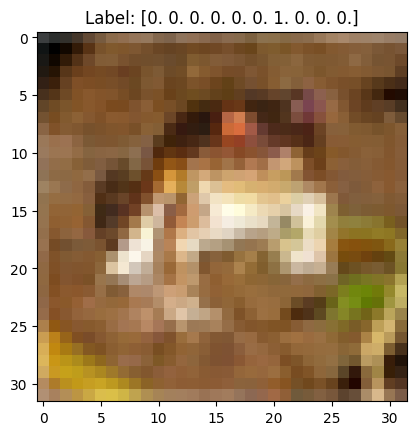

In [ ]:
# Display the first image
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
plt.title(f"Label: {y_train[0]}")
plt.show()

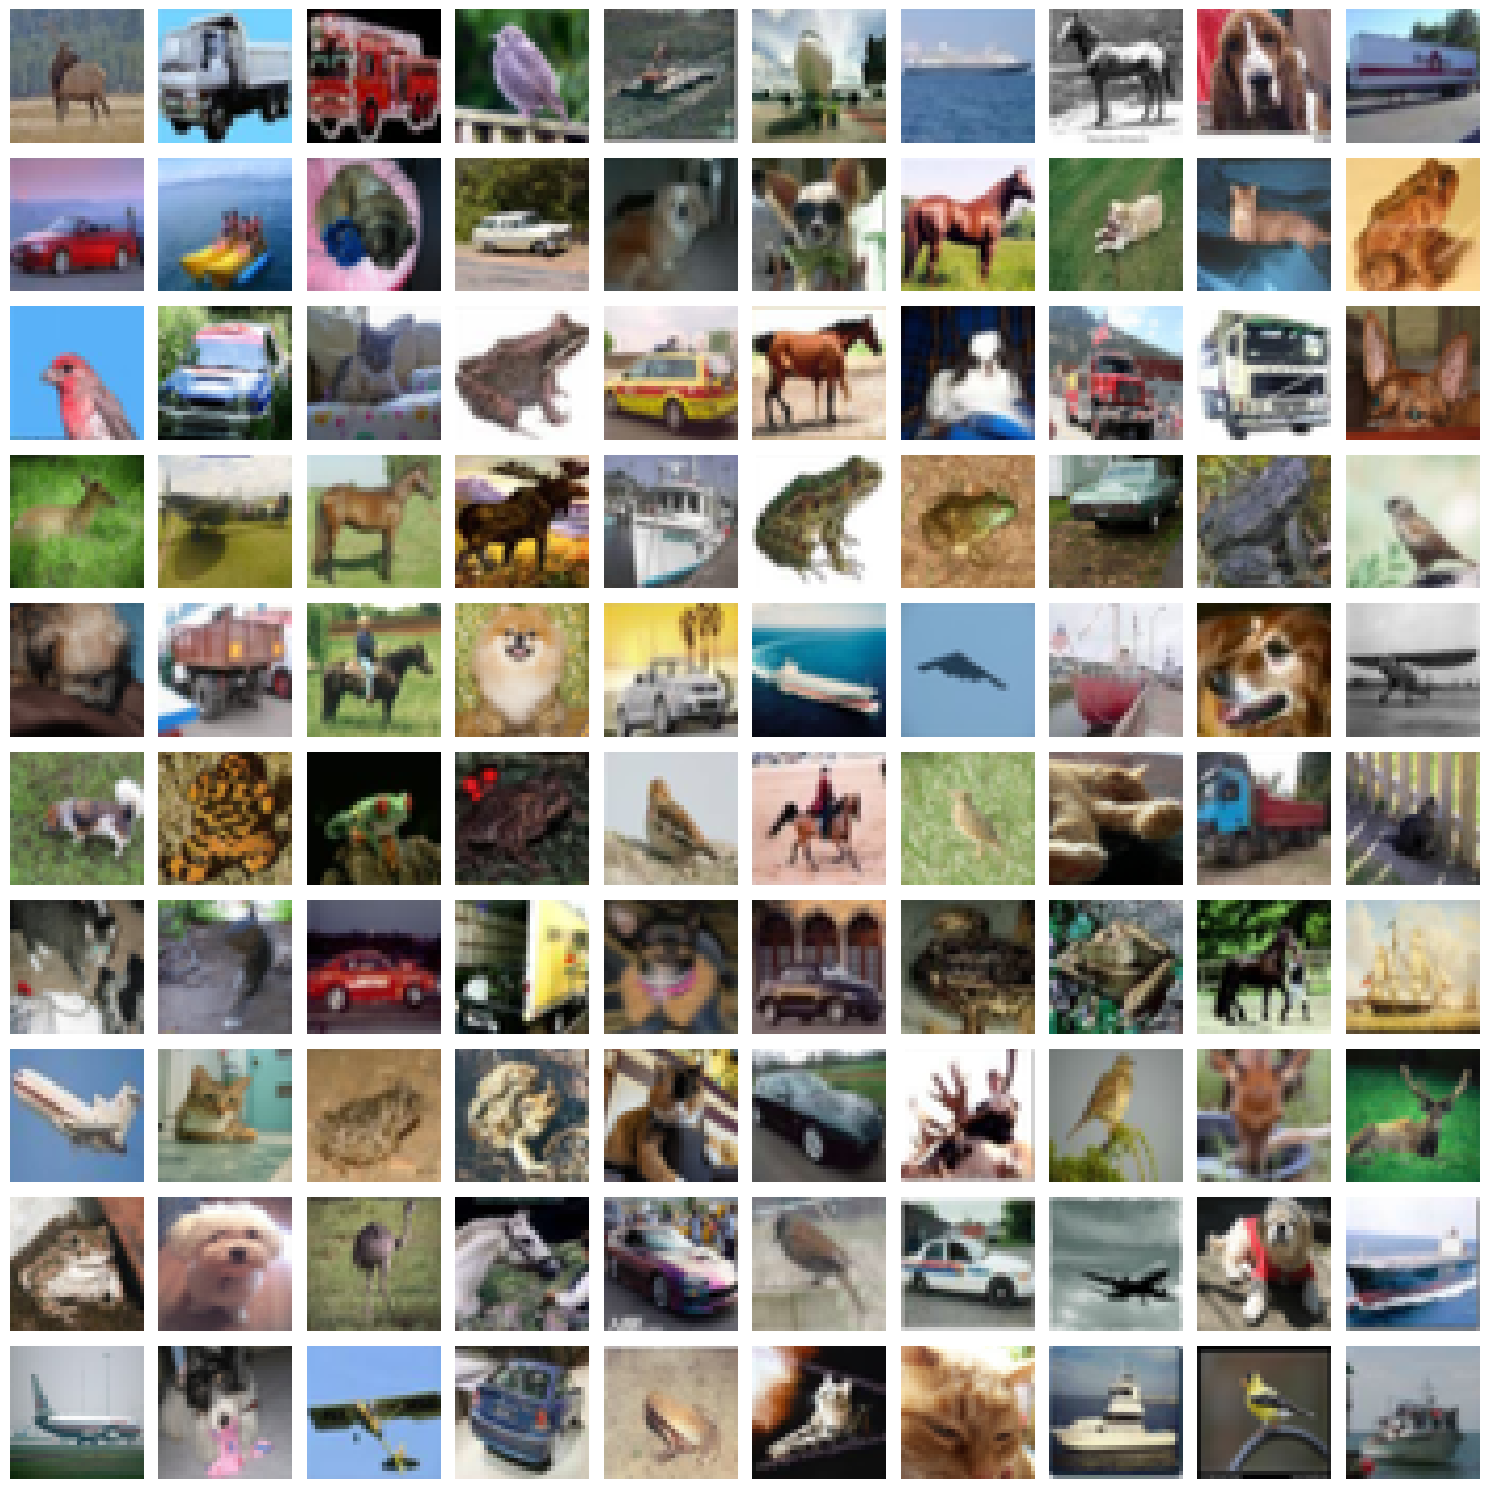

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 10x10 grid
plt.figure(figsize=(15, 15))  # Set the figure size for better visibility

# Randomly select 100 indices
random_indices = np.random.choice(len(x_train), 100, replace=False)

for i, idx in enumerate(random_indices):
    plt.subplot(10, 10, i + 1)  # Create a 10x10 grid
    plt.imshow(x_train[idx], cmap=plt.get_cmap('gray'))  # Display a random image
    plt.axis('off')  # Turn off axes for cleaner visualization

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()

## Importing transfer model - EfficientNetB1 (no tweak)

In [ ]:
import tensorflow as tf  # Import TensorFlow
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Define the model
efficientb1base_model = Sequential()

# Load the pretrained EfficientNetB1 backbone
pretrained_model = EfficientNetB1(
    include_top=False,  # Exclude the top classification layers
    weights="imagenet",  # Use pre-trained weights on ImageNet
    input_shape=(32, 32, 3),  # Input shape for CIFAR-10
    pooling=None,  # Keep spatial dimensions; add pooling later
)

# Freeze the pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Unfreeze the last 20 layers for fine-tuning
# for layer in pretrained_model.layers[-80:]:
#     layer.trainable = True

# # Add the pretrained EfficientNetB1 model to the Sequential model
efficientb1base_model.add(pretrained_model)

# Add a Global Average Pooling layer to reduce spatial dimensions
efficientb1base_model.add(GlobalAveragePooling2D())

# # # Add fully connected layers (classification head)
# efficientb1base_model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
# efficientb1base_model.add(Dropout(0.6))  # Increased dropout
# efficientb1base_model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
# efficientb1base_model.add(Dropout(0.6))  # Increased dropout

# Add the final output layer for CIFAR-10
efficientb1base_model.add(Dense(10, activation='softmax'))  # CIFAR-10 has 10 classes

# Compile the model
efficientb1base_model.compile(
    optimizer='adam',  # Adam optimizer
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Evaluate accuracy during training
)

# Print the model summary
efficientb1base_model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)          │ (None, 1, 1, 1280)          │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,588,049 (25.13 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 6,575,239 (25.08 MB)

In [ ]:
# Compile model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop if no improvement for 10 epochs
    restore_best_weights=True  # Restore the model weights from the best epoch
)

# compile model
efficientb1base_model.compile(optimizer = Adam(learning_rate=0.0001) ,loss='categorical_crossentropy',metrics=['accuracy'])


#Train on cifar-10
batch_size = 512
epochs = 10

# Train the model and store the history
historyb1base = efficientb1base_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[early_stopping])

"""
## Evaluate the trained model
"""

score = efficientb1base_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])



Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 216ms/step - accuracy: 0.1468 - loss: 2.2823 - val_accuracy: 0.2565 - val_loss: 2.1721
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.2583 - loss: 2.1556 - val_accuracy: 0.3232 - val_loss: 2.0663
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3209 - loss: 2.0613 - val_accuracy: 0.3669 - val_loss: 1.9835
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3567 - loss: 1.9838 - val_accuracy: 0.3824 - val_loss: 1.9169
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3741 - loss: 1.9256 - val_accuracy: 0.4027 - val_loss: 1.8627
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3856 - loss: 1.8763 - val_accuracy: 0.4092 - val_loss: 1.8183
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3992 - loss: 1.8333 - val_accuracy: 0.4234 - val_loss: 1.7795
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4075 - loss: 1.7950 - val_accuracy: 0.4319 -

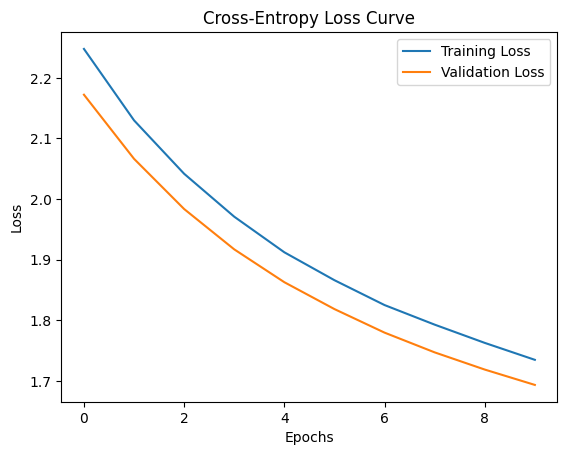

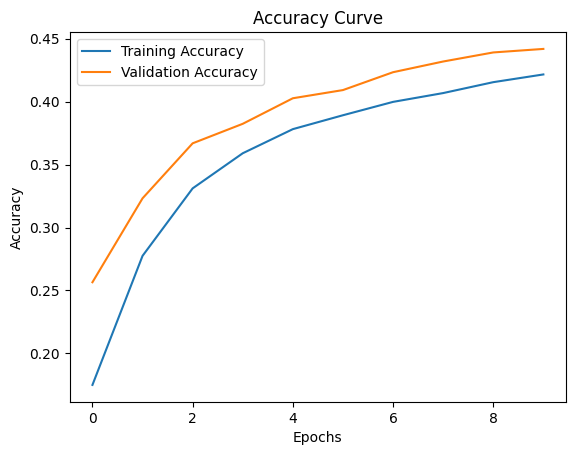

In [ ]:
import matplotlib.pyplot as plt


# Plot the loss curve
plt.figure()
plt.plot(historyb1base.history['loss'], label='Training Loss')
plt.plot(historyb1base.history['val_loss'], label='Validation Loss')
plt.title('Cross-Entropy Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.figure()
plt.plot(historyb1base.history['accuracy'], label='Training Accuracy')
plt.plot(historyb1base.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the trained model

score = efficientb1base_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.6931959390640259
Test accuracy: 0.44190001487731934


313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step


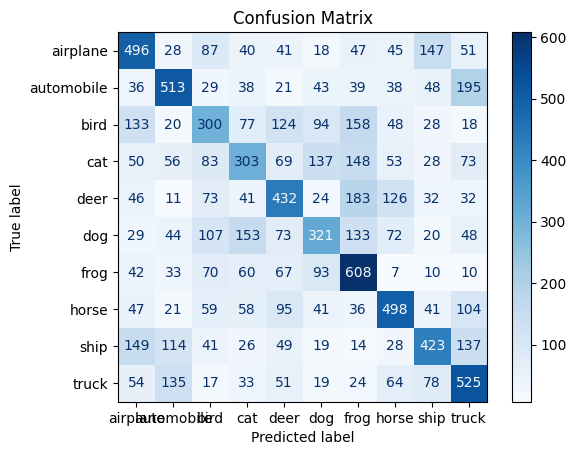

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Predict the test set
y_pred_b1base = efficientb1base_model.predict(x_test)  # Predict probabilities
y_pred_b1base = np.argmax(y_pred_b1base, axis=1)  # Convert probabilities to class labels

# Assuming y_test is in multilabel-indicator format, convert it to multiclass
# Replace this line with the appropriate conversion if y_test has a different format
y_test_multiclass = np.argmax(y_test, axis=1)  # Convert to multiclass if y_test is multilabel-indicator

# Step 2: Compute confusion matrix
# Use the converted y_test_multiclass instead of y_test
cm = confusion_matrix(y_test_multiclass, y_pred_b1base)

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Step 3: Plot confusion matrix with word labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # Use class_names instead of numbers
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Importing transfer model - EfficientNetB1

---



In [ ]:
import tensorflow as tf  # Import TensorFlow
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Define the model
efficientb1_model = Sequential()

# Load the pretrained EfficientNetB1 backbone
pretrained_model = EfficientNetB1(
    include_top=False,  # Exclude the top classification layers
    weights="imagenet",  # Use pre-trained weights on ImageNet
    input_shape=(32, 32, 3),  # Input shape for CIFAR-10
    pooling=None,  # Keep spatial dimensions; add pooling later
)

# Freeze the pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Unfreeze the last 20 layers for fine-tuning
for layer in pretrained_model.layers[-80:]:
    layer.trainable = True

# Add the pretrained EfficientNetB1 model to the Sequential model
efficientb1_model.add(pretrained_model)

# Add a Global Average Pooling layer to reduce spatial dimensions
efficientb1_model.add(GlobalAveragePooling2D())

# Add fully connected layers (classification head)
efficientb1_model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
efficientb1_model.add(Dropout(0.6))  # Increased dropout
efficientb1_model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
efficientb1_model.add(Dropout(0.6))  # Increased dropout

# Add the final output layer for CIFAR-10
efficientb1_model.add(Dense(10, activation='softmax'))  # CIFAR-10 has 10 classes

# Compile the model
efficientb1_model.compile(
    optimizer='adam',  # Adam optimizer
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Evaluate accuracy during training
)

# Print the model summary
efficientb1_model.summary()


27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)          │ (None, 1, 1, 1280)          │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,937,361 (26.46 MB)

 Trainable params: 5,040,538 (19.23 MB)

 Non-trainable params: 1,896,823 (7.24 MB)

In [ ]:
# Compile model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop if no improvement for 10 epochs
    restore_best_weights=True  # Restore the model weights from the best epoch
)

# compile model
efficientb1_model.compile(optimizer = Adam(learning_rate=0.0001) ,loss='categorical_crossentropy',metrics=['accuracy'])


#Train on cifar-10
batch_size = 512
epochs = 16

# Train the model and store the history
historyb1 = efficientb1_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[early_stopping])

"""
## Evaluate the trained model
"""

score = efficientb1_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])



Epoch 1/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 76s 365ms/step - accuracy: 0.1050 - loss: 4.2198 - val_accuracy: 0.0894 - val_loss: 3.5284
Epoch 2/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - accuracy: 0.1146 - loss: 3.5827 - val_accuracy: 0.2337 - val_loss: 3.4601
Epoch 3/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.1315 - loss: 3.4769 - val_accuracy: 0.2640 - val_loss: 3.3736
Epoch 4/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.1590 - loss: 3.3999 - val_accuracy: 0.2933 - val_loss: 3.2831
Epoch 5/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.1860 - loss: 3.3084 - val_accuracy: 0.3459 - val_loss: 3.1463
Epoch 6/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.2284 - loss: 3.1848 - val_accuracy: 0.4077 - val_loss: 2.9994
Epoch 7/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.2822 - loss: 3.0361 - val_accuracy: 0.4473 - val_loss: 2.7791
Epoch 8/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.3323 - loss: 2.8816 - val_accuracy: 0.4827 

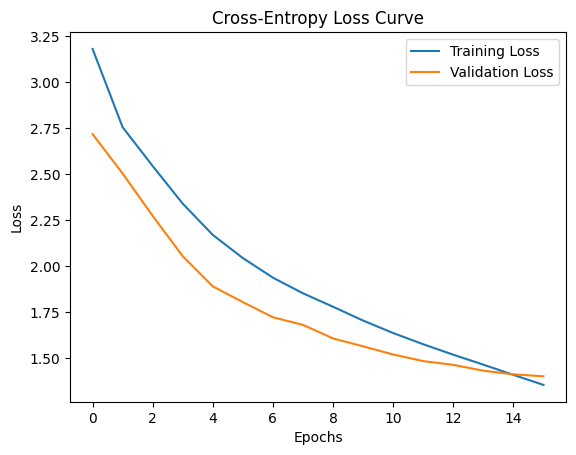

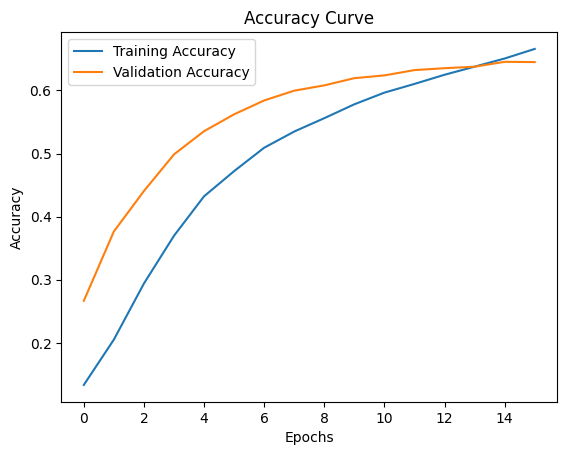

In [ ]:
import matplotlib.pyplot as plt


# Plot the loss curve
plt.figure()
plt.plot(historyb1.history['loss'], label='Training Loss')
plt.plot(historyb1.history['val_loss'], label='Validation Loss')
plt.title('Cross-Entropy Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.figure()
plt.plot(historyb1.history['accuracy'], label='Training Accuracy')
plt.plot(historyb1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the trained model

score = efficientb1_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.4027658700942993
Test accuracy: 0.6449000239372253


313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step


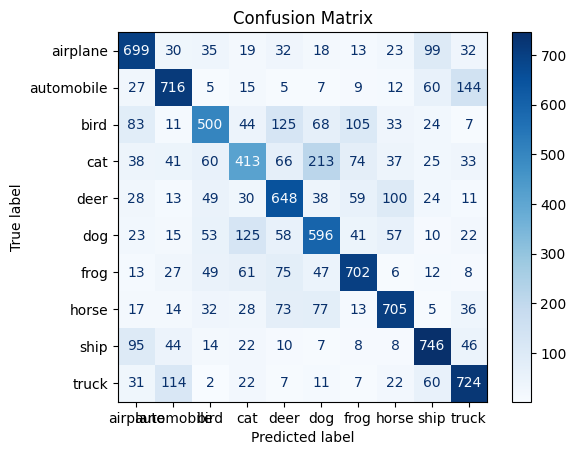

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Predict the test set
y_pred_b1 = efficientb1_model.predict(x_test)  # Predict probabilities
y_pred_b1 = np.argmax(y_pred_b1, axis=1)  # Convert probabilities to class labels

# Assuming y_test is in multilabel-indicator format, convert it to multiclass
# Replace this line with the appropriate conversion if y_test has a different format
y_test_multiclass = np.argmax(y_test, axis=1)  # Convert to multiclass if y_test is multilabel-indicator

# Step 2: Compute confusion matrix
# Use the converted y_test_multiclass instead of y_test
cm = confusion_matrix(y_test_multiclass, y_pred_b1)

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Step 3: Plot confusion matrix with word labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # Use class_names instead of numbers
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Importing transfer model 2 - EfficientNetB1

In [ ]:
import tensorflow as tf  # Import TensorFlow
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Define the model
efficientb1_model2 = Sequential()

# Load the pretrained EfficientNetB1 backbone
pretrained_model = EfficientNetB1(
    include_top=False,  # Exclude the top classification layers
    weights="imagenet",  # Use pre-trained weights on ImageNet
    input_shape=(32, 32, 3),  # Input shape for CIFAR-10
    pooling=None,  # Keep spatial dimensions; add pooling later
)

# Freeze the pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Unfreeze the last 20 layers for fine-tuning
for layer in pretrained_model.layers[-100:]:
    layer.trainable = True

# Add the pretrained EfficientNetB1 model to the Sequential model
efficientb1_model2.add(pretrained_model)

# Add Global Average Pooling to reduce spatial dimensions
efficientb1_model2.add(GlobalAveragePooling2D())  # Flatten spatial dimensions

#Add the Dense layers along with activation and batch normalization
efficientb1_model2.add(Dense(1024,activation=('sigmoid'),input_dim=512))
efficientb1_model2.add(Dense(512,activation=('sigmoid')))
efficientb1_model2.add(Dense(256,activation=('relu')))
#model_1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
efficientb1_model2.add(Dense(1024,activation=('relu')))


# Add the final output layer for CIFAR-10
efficientb1_model2.add(Dense(10, activation='softmax'))  # CIFAR-10 has 10 classes

# Compile the model
efficientb1_model2.compile(
    optimizer='adam',  # Adam optimizer
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Evaluate accuracy during training
)

# Print the model summary
efficientb1_model2.summary()


27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)          │ (None, 1, 1, 1280)          │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,816,529 (33.63 MB)

 Trainable params: 7,455,174 (28.44 MB)

 Non-trainable params: 1,361,355 (5.19 MB)

In [ ]:
# Compile model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau  # Import the ReduceLROnPlateau callback

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Stop if no improvement for 10 epochs
    restore_best_weights=True  # Restore the model weights from the best epoch
)

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Monitor validation loss
    factor=0.5,             # Reduce learning rate by half
    patience=5,             # Wait 3 epochs before reducing the rate
    min_lr=1e-7             # Set a minimum learning rate
)

# Define the optimizer
optimizer = Adam(learning_rate=0.0001)  # Set the initial learning rate

# compile model
efficientb1_model2.compile(
    optimizer = optimizer,  # Initial LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


#Train on cifar-10
batch_size = 512
epochs = 16

# Train the model and store the history
historyb2 = efficientb1_model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[early_stopping])

"""
## Evaluate the trained model
"""

score = efficientb1_model2.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])



Epoch 1/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 393ms/step - accuracy: 0.2298 - loss: 2.1550 - val_accuracy: 0.4447 - val_loss: 1.5353
Epoch 2/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5179 - loss: 1.3406 - val_accuracy: 0.5638 - val_loss: 1.2391
Epoch 3/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5948 - loss: 1.1505 - val_accuracy: 0.6099 - val_loss: 1.1216
Epoch 4/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.6353 - loss: 1.0377 - val_accuracy: 0.6269 - val_loss: 1.0809
Epoch 5/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6642 - loss: 0.9641 - val_accuracy: 0.6354 - val_loss: 1.0456
Epoch 6/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.6900 - loss: 0.8878 - val_accuracy: 0.6400 - val_loss: 1.0547
Epoch 7/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7073 - loss: 0.8437 - val_accuracy: 0.6497 - val_loss: 1.0261
Epoch 8/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7280 - loss: 0.7799 - val_accuracy: 0.6504 -

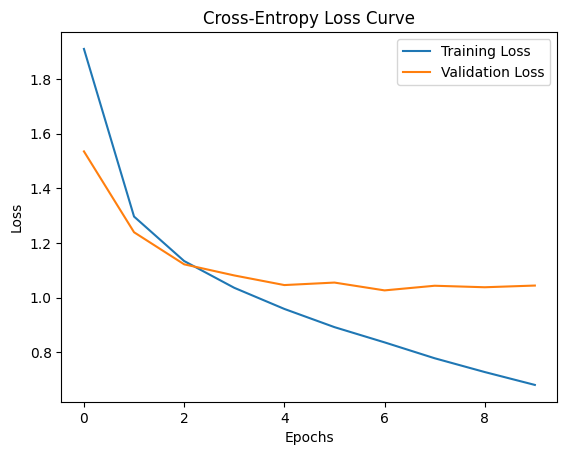

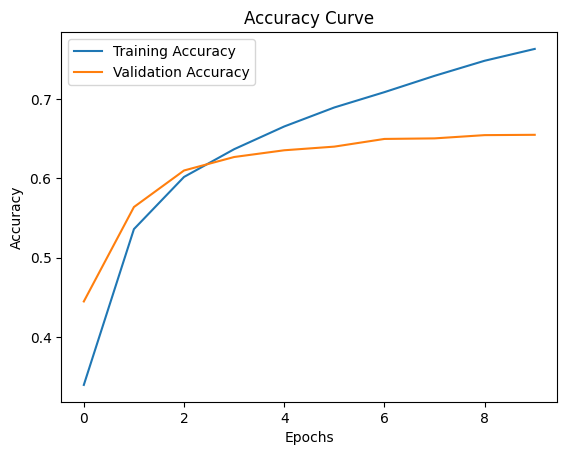

In [ ]:
import matplotlib.pyplot as plt


# Plot the loss curve
plt.figure()
plt.plot(historyb2.history['loss'], label='Training Loss')
plt.plot(historyb2.history['val_loss'], label='Validation Loss')
plt.title('Cross-Entropy Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.figure()
plt.plot(historyb2.history['accuracy'], label='Training Accuracy')
plt.plot(historyb2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the trained model

score = efficientb2_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.4027658700942993
Test accuracy: 0.6449000239372253


313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step


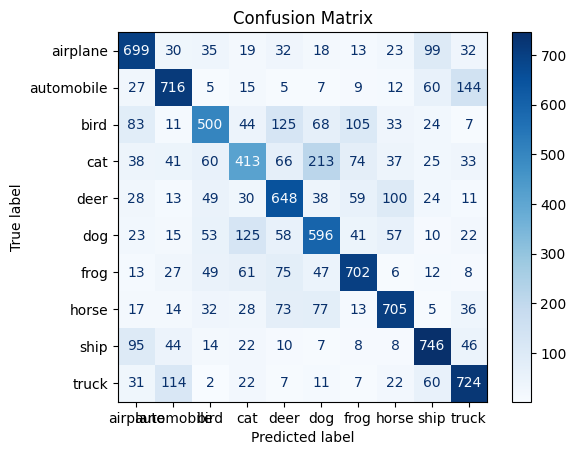

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Predict the test set
y_pred_b2 = efficientb2_model.predict(x_test)  # Predict probabilities
y_pred_b2 = np.argmax(y_pred_b2, axis=1)  # Convert probabilities to class labels

# Assuming y_test is in multilabel-indicator format, convert it to multiclass
# Replace this line with the appropriate conversion if y_test has a different format
y_test_multiclass = np.argmax(y_test, axis=1)  # Convert to multiclass if y_test is multilabel-indicator

# Step 2: Compute confusion matrix
# Use the converted y_test_multiclass instead of y_test
cm = confusion_matrix(y_test_multiclass, y_pred_b2)

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Step 3: Plot confusion matrix with word labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # Use class_names instead of numbers
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Importing transfer model 3 - ResNet101V2

In [ ]:
#  # Normalize data (not working with EfficientNetB1 so commented)

x_train_norm = x_train #/ 255
x_test_norm = x_test #/ 255

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load the ResNet50 base model without the top classification layers
base_model = ResNet50(
    include_top=False,          # Exclude the top layer
    weights='imagenet',         # Use pre-trained weights
    input_shape=(32, 32, 3),    # CIFAR-10 image size
    pooling='avg'               # Use global average pooling
)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 20 layers for fine-tuning
for layer in base_model.layers[-60:]:
    layer.trainable = True


# Define the new sequential model with the provided layers
resnet_model = Sequential()

# Add the base ResNet50 model
resnet_model.add(base_model)

# Add the Flatten layer to convert 2D features into 1D
resnet_model.add(Flatten())

# Add the Dense layers along with activation and batch normalization
resnet_model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
resnet_model.add(Dropout(0.6))  # Increased dropout
resnet_model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
resnet_model.add(Dropout(0.25))  # Increased dropout
resnet_model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
resnet_model.add(Dropout(0.25))  # Increased dropout
resnet_model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
resnet_model.add(Dropout(0.6))  # Increased dropout
resnet_model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
resnet_model.add(Dropout(0.6))  # Increased dropout


# Final classification layer for CIFAR-10 (10 classes)
resnet_model.add(Dense(10, activation='softmax'))

# Compile the model
resnet_model.compile(
    optimizer='adam',                       # Use Adam optimizer
    loss='categorical_crossentropy',        # Multi-class classification loss
    metrics=['accuracy']                    # Track accuracy during training
)

# Print the model summary
resnet_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,294,538 (92.68 MB)

 Trainable params: 18,776,074 (71.63 MB)

 Non-trainable params: 5,518,464 (21.05 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Early stopping callback to prevent overfitting and improve training
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=10,                  # Stop if no improvement for 3 consecutive epochs
    restore_best_weights=True    # Restore the model weights from the best epoch
)

# Compile the model
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-14),  # Adam optimizer with a smaller learning rate
    loss='categorical_crossentropy',      # Loss function for multi-class classification
    metrics=['accuracy']                  # Track accuracy during training
)

# Training parameters
batch_size = 512  # Batch size for training
epochs = 10       # Number of epochs for training

# Train the model and store the training history
historyresnet = resnet_model.fit(
    x_train_norm,                    # Training data
    y_train,                    # Training labels
    batch_size=batch_size,      # Batch size
    epochs=epochs,              # Number of epochs
    validation_data=(x_test, y_test),  # Use test data for validation
    callbacks=[early_stopping]         # Apply early stopping
)

"""
## Evaluate the trained model
"""
# Evaluate the model on the test data
score = resnet_model.evaluate(x_test, y_test, verbose=0)

# Print the test loss and accuracy
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 47s 231ms/step - accuracy: 0.0988 - loss: 5.2627 - val_accuracy: 0.1085 - val_loss: 3.5946
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.1032 - loss: 5.2528 - val_accuracy: 0.1090 - val_loss: 3.5874
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.0988 - loss: 5.2579 - val_accuracy: 0.1119 - val_loss: 3.5883
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.1009 - loss: 5.2494 - val_accuracy: 0.1113 - val_loss: 3.5931
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.1016 - loss: 5.2529 - val_accuracy: 0.1127 - val_loss: 3.5973
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.1007 - loss: 5.2353 - val_accuracy: 0.1117 - val_loss: 3.5991
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.1023 - loss: 5.2436 - val_accuracy: 0.1111 - val_loss: 3.5998
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.1000 - loss: 5.2628 - val_accuracy: 0.1102 -

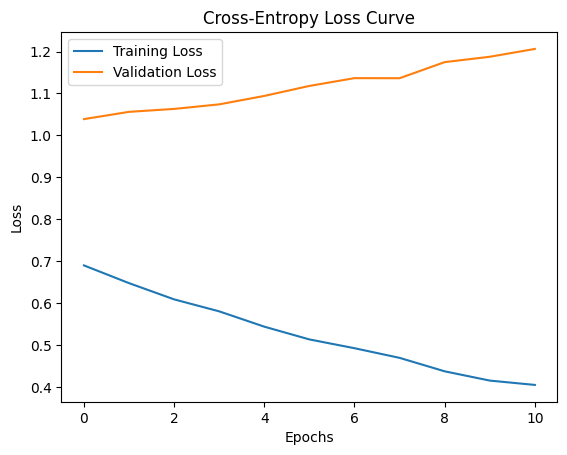

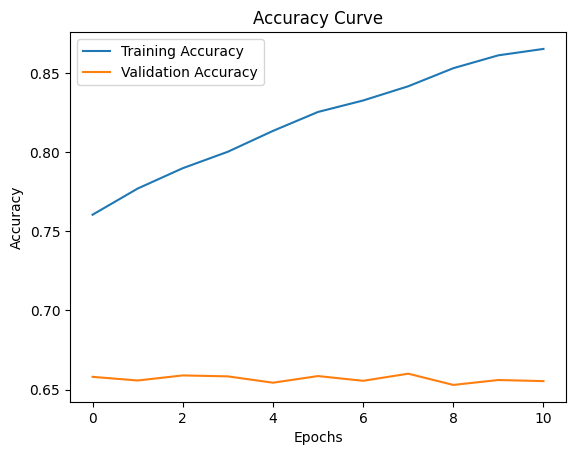

In [ ]:
import matplotlib.pyplot as plt


# Plot the loss curve
plt.figure()
plt.plot(historyresnet.history['loss'], label='Training Loss')
plt.plot(historyresnet.history['val_loss'], label='Validation Loss')
plt.title('Cross-Entropy Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.figure()
plt.plot(historyresnet.history['accuracy'], label='Training Accuracy')
plt.plot(historyresnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the trained model

score = resnet_model.evaluate(x_test_norm, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 3.587388753890991
Test accuracy: 0.10899999737739563


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Predict the test set
y_pred_resnet = resnet_model.predict(x_test_nrom)  # Predict probabilities
y_pred_resnet = np.argmax(y_pred_resnet, axis=1)  # Convert probabilities to class labels

# Assuming y_test is in multilabel-indicator format, convert it to multiclass
# Replace this line with the appropriate conversion if y_test has a different format
y_test_multiclass = np.argmax(y_test, axis=1)  # Convert to multiclass if y_test is multilabel-indicator

# Step 2: Compute confusion matrix
# Use the converted y_test_multiclass instead of y_test
cm = confusion_matrix(y_test_multiclass, y_pred_resnet)

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Step 3: Plot confusion matrix with word labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # Use class_names instead of numbers
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

NameError: name 'efficientb2_model' is not defined

## Importing transfer model 4 - DenseNet121


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Define the model
densenet_model = Sequential()

# Load the ResNet50 base model without the top classification layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# # Unfreeze the last 20 layers for fine-tuning
for layer in base_model.layers[-40:]:
    layer.trainable = True


# Define the new sequential model with the provided layers
densenet_model = Sequential()

# Add the base ResNet50 model
densenet_model.add(base_model)

# Add the Flatten layer to convert 2D features into 1D
densenet_model.add(Flatten())

# Add the Dense layers along with activation and batch normalization
densenet_model.add(Dense(4000, activation='relu'))  # First dense layer
densenet_model.add(Dense(2000, activation='relu'))  # Second dense layer
densenet_model.add(Dropout(0.6))                    # Dropout layer (40%)
densenet_model.add(Dense(1000, activation='relu'))  # Third dense layer
densenet_model.add(Dropout(0.5))                    # Dropout layer (30%)
densenet_model.add(Dense(500, activation='relu'))   # Fourth dense layer
densenet_model.add(Dropout(0.1))                    # Dropout layer (20%)

# Final classification layer for CIFAR-10 (10 classes)
densenet_model.add(Dense(10, activation='softmax'))

# Compile the model
densenet_model.compile(
    optimizer='adam',                       # Use Adam optimizer
    loss='categorical_crossentropy',        # Multi-class classification loss
    metrics=['accuracy']                    # Track accuracy during training
)

# Print the model summary
densenet_model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 1, 1, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 4000)                │       4,100,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 2000)                │       8,002,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 2000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1000)                │       2,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 500)                 │         500,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 10)                  │           5,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,646,014 (82.57 MB)

 Trainable params: 15,436,222 (58.88 MB)

 Non-trainable params: 6,209,792 (23.69 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Early stopping callback to prevent overfitting and improve training
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=10,                  # Stop if no improvement for 3 consecutive epochs
    restore_best_weights=True    # Restore the model weights from the best epoch
)

# Compile the model
densenet_model.compile(
    optimizer=Adam(learning_rate=1e-14),  # Adam optimizer with a smaller learning rate
    loss='categorical_crossentropy',      # Loss function for multi-class classification
    metrics=['accuracy']                  # Track accuracy during training
)

# Training parameters
batch_size = 512  # Batch size for training
epochs = 16       # Number of epochs for training

# Train the model and store the training history
historydensenet = densenet_model.fit(
    x_train,                    # Training data
    y_train,                    # Training labels
    batch_size=batch_size,      # Batch size
    epochs=epochs,              # Number of epochs
    validation_data=(x_test, y_test),  # Use test data for validation
    callbacks=[early_stopping]         # Apply early stopping
)

"""
## Evaluate the trained model
"""
# Evaluate the model on the test data
score = densenet_model.evaluate(x_test, y_test, verbose=0)

# Print the test loss and accuracy
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Epoch 1/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 56s 293ms/step - accuracy: 0.1039 - loss: 2.7829 - val_accuracy: 0.0980 - val_loss: 2.4271
Epoch 2/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.0996 - loss: 2.7840 - val_accuracy: 0.1018 - val_loss: 2.3908
Epoch 3/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.1013 - loss: 2.7800 - val_accuracy: 0.1043 - val_loss: 2.3876
Epoch 4/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.0997 - loss: 2.7895 - val_accuracy: 0.1059 - val_loss: 2.3917
Epoch 5/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.1007 - loss: 2.7869 - val_accuracy: 0.1055 - val_loss: 2.3962
Epoch 6/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.1030 - loss: 2.7755 - val_accuracy: 0.1055 - val_loss: 2.3989
Epoch 7/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.1027 - loss: 2.7817 - val_accuracy: 0.1055 - val_loss: 2.3999
Epoch 8/16
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.1030 - loss: 2.7726 - val_accuracy: 0.1057 -

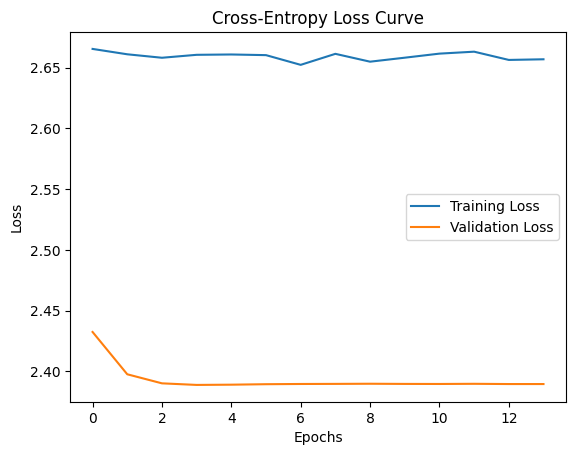

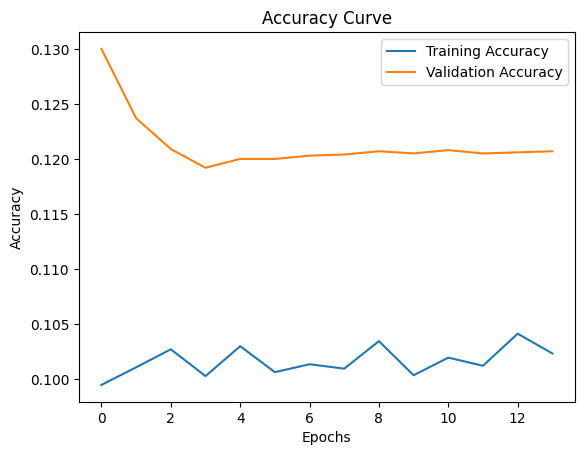

In [ ]:
import matplotlib.pyplot as plt


# Plot the loss curve
plt.figure()
plt.plot(historydensenet.history['loss'], label='Training Loss')
plt.plot(historydensenet.history['val_loss'], label='Validation Loss')
plt.title('Cross-Entropy Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.figure()
plt.plot(historydensenet.history['accuracy'], label='Training Accuracy')
plt.plot(historydensenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the trained model

score = densenet_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.3876302242279053
Test accuracy: 0.10429999977350235


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Predict the test set
y_pred_densenet = densenet_model.predict(x_test)  # Predict probabilities
y_pred_densenet = np.argmax(y_pred_densenet, axis=1)  # Convert probabilities to class labels

# Assuming y_test is in multilabel-indicator format, convert it to multiclass
# Replace this line with the appropriate conversion if y_test has a different format
y_test_multiclass = np.argmax(y_test, axis=1)  # Convert to multiclass if y_test is multilabel-indicator

# Step 2: Compute confusion matrix
# Use the converted y_test_multiclass instead of y_test
cm = confusion_matrix(y_test_multiclass, y_pred_resnet)

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Step 3: Plot confusion matrix with word labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # Use class_names instead of numbers
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

NameError: name 'efficientb2_model' is not defined

# Model comparison

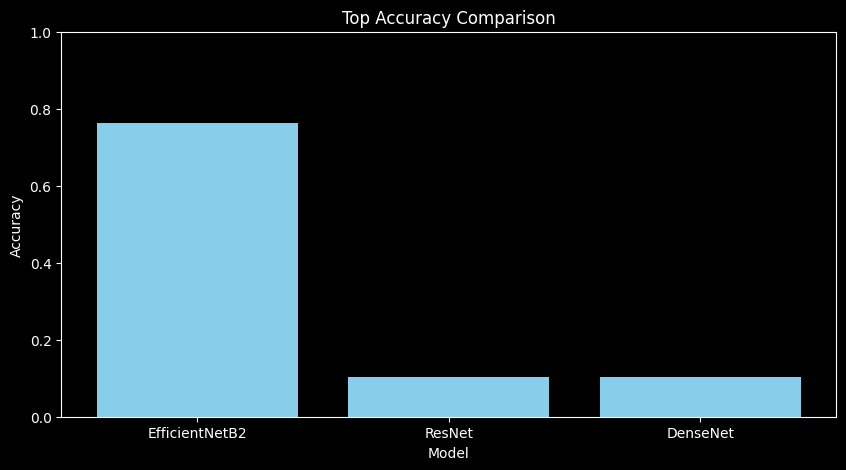

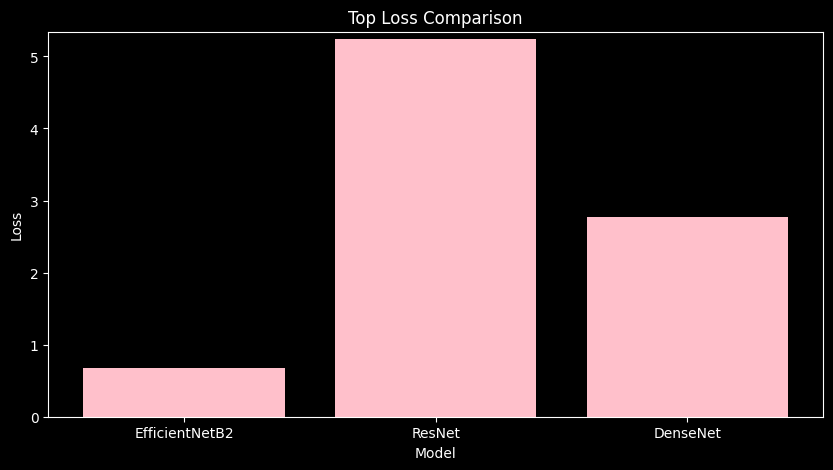

In [ ]:
import matplotlib.pyplot as plt

# Apply a dark theme
plt.style.use('dark_background')

# Assuming the history objects contain a 'history' attribute with 'accuracy' and 'loss' keys
histories = {
    "EfficientNetB2": historyb2.history,
    "ResNet": historyresnet.history,
    "DenseNet": historydensenet.history
}

# Extract the top accuracy and loss values
top_accuracies = {model: max(data['accuracy']) for model, data in histories.items()}
top_losses = {model: min(data['loss']) for model, data in histories.items()}

# Plot top accuracy
plt.figure(figsize=(10, 5))
plt.bar(top_accuracies.keys(), top_accuracies.values(), color='#87CEEB')  # Pastel blue
plt.title('Top Accuracy Comparison', color='white')
plt.ylabel('Accuracy', color='white')
plt.xlabel('Model', color='white')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

# Plot top loss
plt.figure(figsize=(10, 5))
plt.bar(top_losses.keys(), top_losses.values(), color='#FFC0CB')  # Pastel pink
plt.title('Top Loss Comparison', color='white')
plt.ylabel('Loss', color='white')
plt.xlabel('Model', color='white')
plt.ylim(0, max(top_losses.values()) + 0.1)  # Adjusting limit based on loss range
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()
